Loading train/test splits...
Running Grid Search for Random Forest (tuning `n_estimators`)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters (Random Forest):
{'n_estimators': 100}
Best Cross-Validated F1-Score: 0.1213

Test Set Results:
Accuracy: 0.8491

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       719
           1       0.53      0.06      0.11       129

    accuracy                           0.85       848
   macro avg       0.69      0.53      0.51       848
weighted avg       0.81      0.85      0.79       848



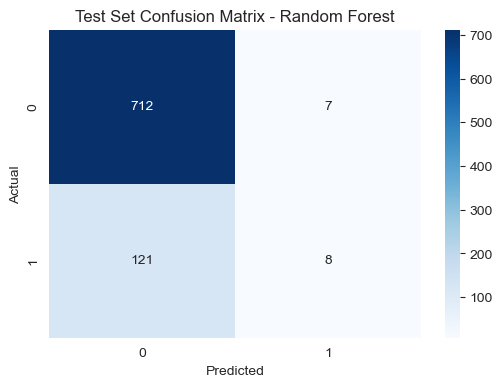

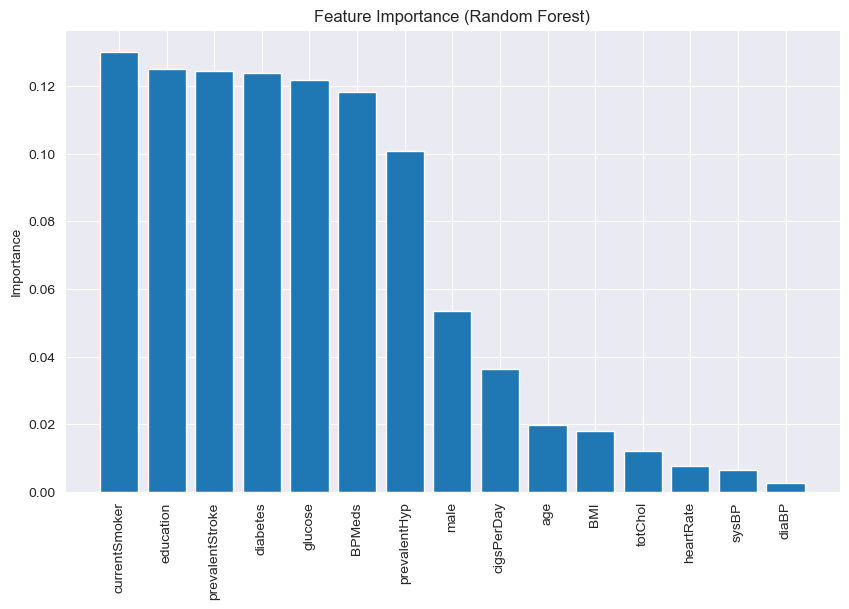

Random Forest model saved to ../models/random_forest_best_model.pkl
Grid search results saved to ../results/random_forest_gridsearch_results.csv


In [4]:
# --- 03_random_forest_tune_trees.ipynb ---

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# 1. Load preprocessed data
print("Loading train/test splits...")
X_train = np.load("../data/splits/X_train.npy")
y_train = np.load("../data/splits/y_train.npy")
X_test = np.load("../data/splits/X_test.npy")
y_test = np.load("../data/splits/y_test.npy")

# 2. Set up GridSearchCV for Random Forest, tuning only `n_estimators`
param_grid = {
    'n_estimators': [100, 200, 300, 500],  # Number of trees in the forest
}

# Use GridSearchCV to tune the `n_estimators` hyperparameter
grid_search = GridSearchCV(
    #RandomForestClassifier(random_state=42, class_weight='balanced'),
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='f1',  # Optimize for F1-Score (important for imbalanced data)
    cv=5,          # 5-fold cross-validation
    verbose=2,
    n_jobs=-1      # Use all cores for parallel processing
)

# 3. Run Grid Search
print("Running Grid Search for Random Forest (tuning `n_estimators`)...")
grid_search.fit(X_train, y_train)

# 4. Best Hyperparameters
print("\nBest Parameters (Random Forest):")
print(grid_search.best_params_)
print(f"Best Cross-Validated F1-Score: {grid_search.best_score_:.4f}\n")

# 5. Evaluate the best model on test set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)

# 6. Evaluation metrics
print("Test Set Results:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print()
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# 7. Confusion Matrix for test set
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix - Random Forest")
plt.show()

# Assuming X_train_columns is available (i.e., feature names)
X_train_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

# ==============================
# Feature Importance Plot
# ==============================
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [X_train_columns[i] for i in indices], rotation=90)
plt.ylabel('Importance')
plt.show()


# 9. Save the best model
os.makedirs("../models", exist_ok=True)
model_path = "../models/random_forest_best_model.pkl"
joblib.dump(best_model, model_path)
print(f"Random Forest model saved to {model_path}")

# 10. (Optional) Save GridSearch Results to CSV
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv("../results/random_forest_gridsearch_results.csv", index=False)
print("Grid search results saved to ../results/random_forest_gridsearch_results.csv")
